# Predictive Analysis using Prophet

### Import Required library

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from prophet import Prophet
from datetime import datetime
warnings.simplefilter("ignore")

c:\Users\hafto\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read clean data

In [2]:
#Read cleaned emission and carbon captured data
emission_cc_data = pd.read_csv('data\cleaned_data.csv')

In [3]:
#print data set info
emission_cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          68 non-null     object 
 1   year             68 non-null     int64  
 2   total_ghg        68 non-null     float64
 3   max_capacity_mt  68 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.2+ KB


In [4]:
#look for missing values
emission_cc_data.isna().sum()

country            0
year               0
total_ghg          0
max_capacity_mt    0
dtype: int64

In [5]:
#data stats
emission_cc_data.describe()

,year,total_ghg,max_capacity_mt
count,68.000000,68.000000,68.000000
mean,2015.897059,2071.630882,4.719443
std,4.190037,3168.864247,5.997632
min,2006.000000,28.420000,0.100000
25%,2012.000000,138.152500,1.000000
50%,2018.000000,505.135000,2.575000
75%,2019.000000,2316.357500,5.602500
max,2020.000000,10963.380000,32.140000


In [6]:
#Convert Year to date data type
emission_cc_data['year'] = emission_cc_data['year'].apply(lambda year: datetime(int(year), 12, 31))
emission_cc_data

,country,year,total_ghg,max_capacity_mt
0,Australia,2009-12-31,578.99,4.00000
1,Australia,2010-12-31,562.21,5.91000
2,Australia,2018-12-31,586.60,4.51000
3,Australia,2019-12-31,577.24,21.70000
4,Austria,2020-12-31,58.14,0.70000
...,...,...,...,...
63,United States,2016-12-31,5246.25,4.83000
64,United States,2017-12-31,5197.07,4.90000
65,United States,2018-12-31,5384.61,4.30000
66,United States,2019-12-31,5279.34,14.90000


In [7]:
# filter data to remove 2007 - 2020
emission_cc_data = emission_cc_data.loc[emission_cc_data['year'] <= '2020-01-01']

#filter united states
us_data = emission_cc_data.loc[emission_cc_data['country'] == 'United States']

#filter rest of the world data
rest_world_data = emission_cc_data.loc[emission_cc_data['country'] != 'United States']

#print us data
display(us_data.head())

#print rest of the world data
display(rest_world_data.head())

,country,year,total_ghg,max_capacity_mt
58,United States,2008-12-31,5634.80,7.8200
59,United States,2009-12-31,5255.68,7.8300
60,United States,2010-12-31,5500.53,1.0569
61,United States,2011-12-31,5304.66,1.2000
62,United States,2013-12-31,5234.12,14.0000


,country,year,total_ghg,max_capacity_mt
0,Australia,2009-12-31,578.99,4.000
1,Australia,2010-12-31,562.21,5.910
2,Australia,2018-12-31,586.60,4.510
3,Australia,2019-12-31,577.24,21.700
5,Belgium,2011-12-31,100.54,0.125


In [8]:
#Aggregate data to year and 
#us data
yearly_us_data = us_data.groupby('year').aggregate({'total_ghg':'sum','max_capacity_mt':'sum'}).reset_index()

#rest of world data
yearly_world_data = rest_world_data.groupby('year').aggregate({'total_ghg':'sum','max_capacity_mt':'sum'}).reset_index()

#print head
display(yearly_us_data.head())

display(yearly_world_data.head())

,year,total_ghg,max_capacity_mt
0,2008-12-31,5634.80,7.8200
1,2009-12-31,5255.68,7.8300
2,2010-12-31,5500.53,1.0569
3,2011-12-31,5304.66,1.2000
4,2013-12-31,5234.12,14.0000


,year,total_ghg,max_capacity_mt
0,2006-12-31,6906.26,0.60
1,2007-12-31,158.13,0.80
2,2008-12-31,1948.84,1.10
3,2009-12-31,1464.53,5.20
4,2010-12-31,562.21,5.91


### Predictive analysis for emission and carbon capture data using prophet 

In [9]:
#separate data to green hous gas and carbon capture for united 
warnings.simplefilter("ignore")
us_emission, us_cc = yearly_us_data[['year','total_ghg']], yearly_us_data[['year','max_capacity_mt']]

#rename columns to ds and y
us_emission.rename(columns={'year':'ds','total_ghg':'y'},inplace= True)
us_cc.rename(columns={'year':'ds','max_capacity_mt':'y'},inplace= True)

display(us_emission.head())
display(us_cc.head())

,ds,y
0,2008-12-31,5634.80
1,2009-12-31,5255.68
2,2010-12-31,5500.53
3,2011-12-31,5304.66
4,2013-12-31,5234.12


,ds,y
0,2008-12-31,7.8200
1,2009-12-31,7.8300
2,2010-12-31,1.0569
3,2011-12-31,1.2000
4,2013-12-31,14.0000


In [10]:
#Create a prophet model instance 
us_emission_model = Prophet()
us_cc_model = Prophet()

#fit models
us_emission_model.fit(us_emission)
us_cc_model.fit(us_cc)

#Create future data
future_dataframe = us_cc_model.make_future_dataframe(periods=12,freq = 'y')

future_dataframe.head()

21:17:32 - cmdstanpy - INFO - Chain [1] start processing
21:17:32 - cmdstanpy - INFO - Chain [1] done processing
21:17:32 - cmdstanpy - INFO - Chain [1] start processing
21:17:32 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2008-12-31
1,2009-12-31
2,2010-12-31
3,2011-12-31
4,2013-12-31


In [11]:
#Make prediction
us_emission_forecast = us_emission_model.predict(future_dataframe)
us_cc_forecast = us_cc_model.predict(future_dataframe)

#print both forecast
display(us_emission_forecast.head(5))
display(us_cc_forecast.head(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-12-31,1935.114286,5305.523071,5607.852494,1935.114286,1935.114286,3521.896593,3521.896593,3521.896593,3521.896593,3521.896593,3521.896593,0.0,0.0,0.0,5457.010879
1,2009-12-31,1916.469721,5259.959220,5551.686420,1916.469721,1916.469721,3487.364441,3487.364441,3487.364441,3487.364441,3487.364441,3487.364441,0.0,0.0,0.0,5403.834162
2,2010-12-31,1897.825157,5244.896922,5526.816409,1897.825157,1897.825157,3487.682257,3487.682257,3487.682257,3487.682257,3487.682257,3487.682257,0.0,0.0,0.0,5385.507414
3,2011-12-31,1879.180593,5252.354879,5547.021865,1879.180593,1879.180593,3522.803518,3522.803518,3522.803518,3522.803518,3522.803518,3522.803518,0.0,0.0,0.0,5401.984111
4,2013-12-31,1842.269223,5185.562190,5465.795902,1842.269223,1842.269223,3487.364441,3487.364441,3487.364441,3487.364441,3487.364441,3487.364441,0.0,0.0,0.0,5329.633664


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-12-31,0.458942,0.319762,11.442800,0.458942,0.458942,5.223321,5.223321,5.223321,5.223321,5.223321,5.223321,0.0,0.0,0.0,5.682264
1,2009-12-31,0.801618,-0.430791,11.008471,0.801618,0.801618,4.674473,4.674473,4.674473,4.674473,4.674473,4.674473,0.0,0.0,0.0,5.476091
2,2010-12-31,1.144294,-0.297698,10.643659,1.144294,1.144294,4.129325,4.129325,4.129325,4.129325,4.129325,4.129325,0.0,0.0,0.0,5.273619
3,2011-12-31,1.486969,-0.365394,10.339775,1.486969,1.486969,3.588546,3.588546,3.588546,3.588546,3.588546,3.588546,0.0,0.0,0.0,5.075515
4,2013-12-31,2.173259,1.677900,12.330891,2.173259,2.173259,4.674473,4.674473,4.674473,4.674473,4.674473,4.674473,0.0,0.0,0.0,6.847732


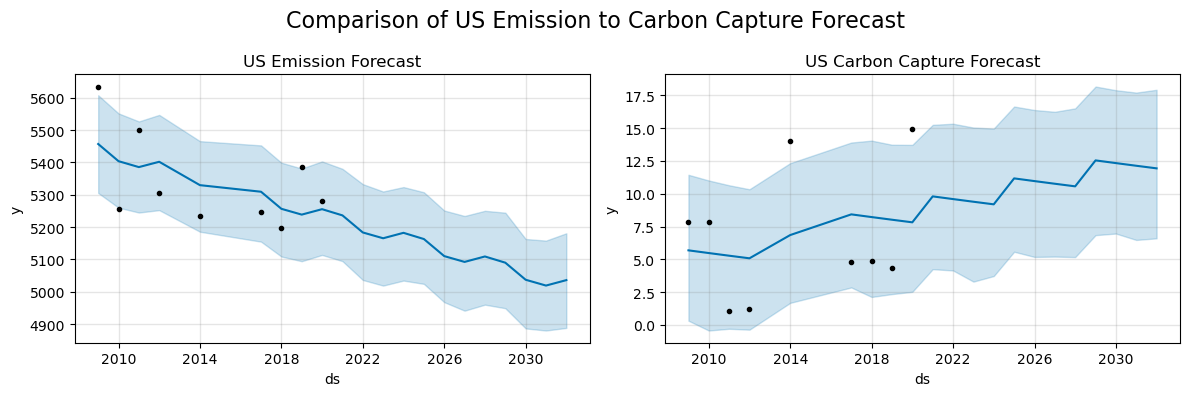

In [12]:
#plot forecast us emission and carbon capture data

fig, ax = plt.subplots(1,2, figsize=(12, 4))
# Plot for the US forecast
us_emission_model.plot(us_emission_forecast, ax=ax[0])
ax[0].set_title('US Emission Forecast')

# Plot for the World forecast
us_cc_model.plot(us_cc_forecast, ax=ax[1])
ax[1].set_title('US Carbon Capture Forecast')

fig.suptitle('Comparison of US Emission to Carbon Capture Forecast', fontsize=16)
plt.tight_layout()
plt.show()

warnings.simplefilter("ignore")

### Predictive analysis for emission and carbon capture data using prophet

In [13]:
#separate data to green hous gas and carbon capture for united 
warnings.simplefilter("ignore")
world_emission, world_cc = yearly_world_data[['year','total_ghg']], yearly_world_data[['year','max_capacity_mt']]

#rename columns to ds and y
world_emission.rename(columns={'year':'ds','total_ghg':'y'},inplace= True)
world_cc.rename(columns={'year':'ds','max_capacity_mt':'y'},inplace= True)

display(world_emission.head())
display(world_cc.head())

,ds,y
0,2006-12-31,6906.26
1,2007-12-31,158.13
2,2008-12-31,1948.84
3,2009-12-31,1464.53
4,2010-12-31,562.21


,ds,y
0,2006-12-31,0.60
1,2007-12-31,0.80
2,2008-12-31,1.10
3,2009-12-31,5.20
4,2010-12-31,5.91


In [14]:
#Create a prophet model instance 
world_emission_model = Prophet()
world_cc_model = Prophet()

#fit models
world_emission_model.fit(world_emission)
world_cc_model.fit(world_cc)

21:17:33 - cmdstanpy - INFO - Chain [1] start processing
21:17:33 - cmdstanpy - INFO - Chain [1] done processing
21:17:34 - cmdstanpy - INFO - Chain [1] start processing
21:17:34 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
#Make prediction
world_emission_forecast = world_emission_model.predict(future_dataframe)
world_cc_forecast = world_cc_model.predict(future_dataframe)

#print both forecast
display(world_emission_forecast.head(5))
display(world_cc_forecast.head(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-12-31,2214.325301,-4355.351823,7042.190455,2214.325301,2214.325301,-747.445790,-747.445790,-747.445790,-747.445790,-747.445790,-747.445790,0.0,0.0,0.0,1466.879511
1,2009-12-31,2734.739967,-2805.540413,8757.467535,2734.739967,2734.739967,576.734733,576.734733,576.734733,576.734733,576.734733,576.734733,0.0,0.0,0.0,3311.474701
2,2010-12-31,3255.154634,-570.887249,11035.196011,3255.154634,3255.154634,1923.823777,1923.823777,1923.823777,1923.823777,1923.823777,1923.823777,0.0,0.0,0.0,5178.978411
3,2011-12-31,3775.569300,1351.994514,13113.357359,3775.569300,3775.569300,3292.182242,3292.182242,3292.182242,3292.182242,3292.182242,3292.182242,0.0,0.0,0.0,7067.751542
4,2013-12-31,4817.824426,-487.368578,11144.627875,4817.824426,4817.824426,576.734733,576.734733,576.734733,576.734733,576.734733,576.734733,0.0,0.0,0.0,5394.559159


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-12-31,15.815397,-27.970724,4.787775,15.815397,15.815397,-26.090829,-26.090829,-26.090829,-26.090829,-26.090829,-26.090829,0.0,0.0,0.0,-10.275432
1,2009-12-31,18.217693,-18.704265,16.296345,18.217693,18.217693,-19.535853,-19.535853,-19.535853,-19.535853,-19.535853,-19.535853,0.0,0.0,0.0,-1.318161
2,2010-12-31,20.619988,-9.404775,26.168666,20.619988,20.619988,-12.734372,-12.734372,-12.734372,-12.734372,-12.734372,-12.734372,0.0,0.0,0.0,7.885616
3,2011-12-31,23.022284,0.095924,35.264715,23.022284,23.022284,-5.694651,-5.694651,-5.694651,-5.694651,-5.694651,-5.694651,0.0,0.0,0.0,17.327632
4,2013-12-31,27.833456,-9.724619,26.483866,27.833456,27.833456,-19.535853,-19.535853,-19.535853,-19.535853,-19.535853,-19.535853,0.0,0.0,0.0,8.297603


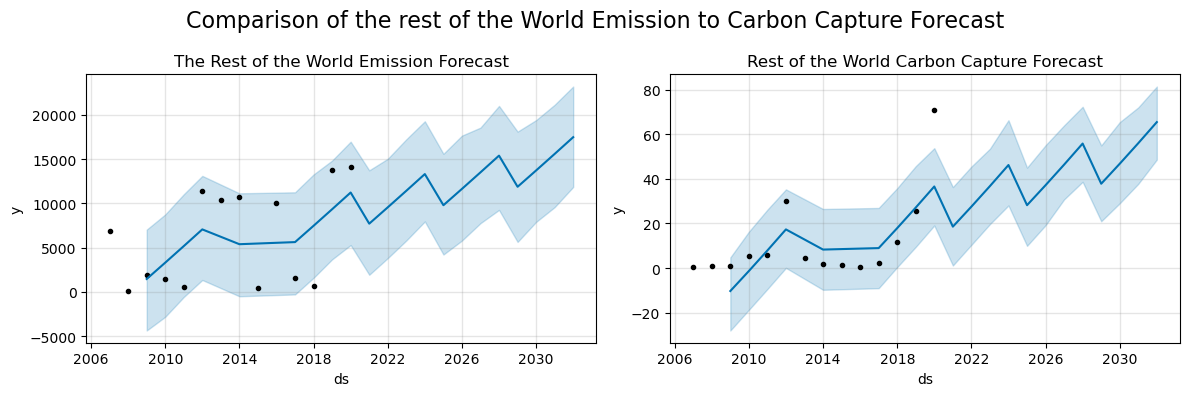

In [16]:
#plot forecast World emission and carbon capture data

fig, ax = plt.subplots(1,2, figsize=(12, 4))

# Plot for the world forecast
world_emission_model.plot(world_emission_forecast, ax=ax[0])
ax[0].set_title('The Rest of the World Emission Forecast')

# Plot for the World forecast
world_cc_model.plot(world_cc_forecast, ax=ax[1])
ax[1].set_title('Rest of the World Carbon Capture Forecast')

fig.suptitle('Comparison of the rest of the World Emission to Carbon Capture Forecast', fontsize=16)
plt.tight_layout()
plt.show()

### Compare US vs The rest of the world forecast

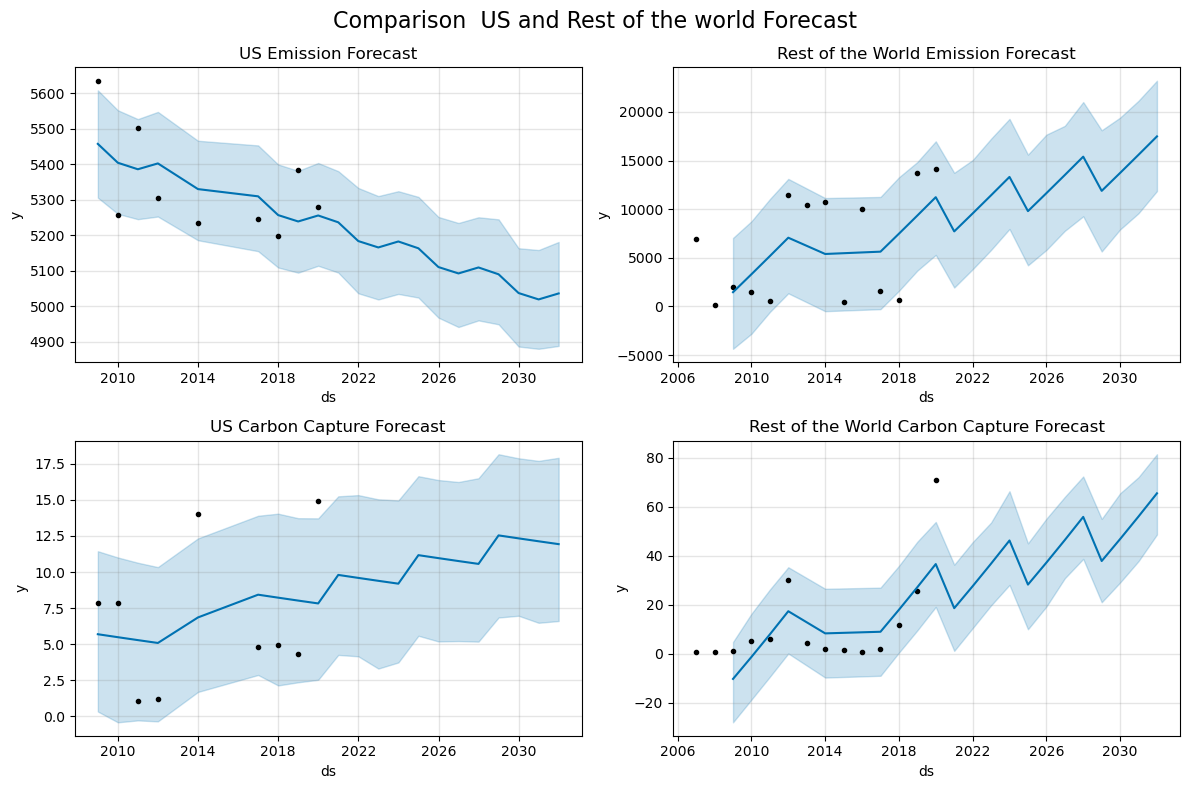

In [17]:
#PLot US and the rest of the world forecast
# Plot forecasts side by side
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 8))

# Plot for the US forecast
us_emission_model.plot(us_emission_forecast, ax=ax[0,0])
ax[0,0].set_title('US Emission Forecast')

# Plot for the World forecast
world_emission_model.plot(world_emission_forecast, ax=ax[0,1])
ax[0,1].set_title('Rest of the World Emission Forecast')

us_cc_model.plot(us_cc_forecast, ax=ax[1,0])
ax[1,0].set_title('US Carbon Capture Forecast')

# Plot for the World forecast
world_cc_model.plot(world_cc_forecast, ax=ax[1,1])
ax[1,1].set_title('Rest of the World Carbon Capture Forecast')
fig.suptitle('Comparison  US and Rest of the world Forecast', fontsize=16)
plt.tight_layout()

# Show the plots
plt.show()
